# PulsarPrediction

## Introduction

In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))
suppressMessages(library(qdap))
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”


ERROR: Error in library(qdap): there is no package called ‘qdap’


In [4]:
pulsar_training = read_csv("pulsar_data_train.csv")
pulsar_training = na.omit(pulsar_training)


Parsed with column specification:
cols(
  `Mean of the integrated profile` = col_double(),
  `Standard deviation of the integrated profile` = col_double(),
  `Excess kurtosis of the integrated profile` = col_double(),
  `Skewness of the integrated profile` = col_double(),
  `Mean of the DM-SNR curve` = col_double(),
  `Standard deviation of the DM-SNR curve` = col_double(),
  `Excess kurtosis of the DM-SNR curve` = col_double(),
  `Skewness of the DM-SNR curve` = col_double(),
  target_class = col_double()
)



In [5]:
pulsar_names = c()
for(n in names(pulsar_training)){
    acroynm = ''
    for(word in str_split(n, ' ')){
        acroynm = paste(acroynm,substr(word,1,1), sep = '', collapse='')
    }
    pulsar_names = c(pulsar_names,acroynm)
}
names(pulsar_training)<-pulsar_names
pulsar_training




Motip,Sdotip,Ekotip,Sotip,MotDc,SdotDc,EkotDc,SotDc,t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121.15625,48.37297,0.37548466,-0.01316549,3.1688963,18.399367,7.4498741,65.1592977,0
76.96875,36.17556,0.71289786,3.38871856,2.3996656,17.570997,9.4146523,102.7229747,0
130.58594,53.22953,0.13340829,-0.29724164,2.7433110,22.362553,8.5083638,74.0313242,0
84.80469,36.11766,0.82501279,3.27412537,2.7901338,20.618009,8.4050084,76.2911279,0
109.40625,55.91252,0.56510595,0.05624666,2.7976589,19.496527,9.4432821,97.3745784,0
95.00781,40.21981,0.34757810,1.15316438,2.7700669,18.217741,7.8512050,70.8019377,0
130.08594,46.40262,-0.04658483,-0.03446839,5.0501672,27.997476,6.0598494,38.1547859,0
96.93750,40.53736,0.41940557,0.75582938,1.9715719,11.636964,11.6291195,202.6866400,0
146.69531,47.80618,-0.46841878,0.55492631,2.8854515,18.043781,9.7924207,112.6258021,0


In [11]:
# aov(t ~ Motip, data=pulsar_training)
summary(aov(t ~ Motip, data=pulsar_training))
# residuals(aov(t ~ Motip, data=pulsar_training))
aov.models = pulsar_training %>%
  map(~ summary(aov(pulsar_training$t ~ .x))[[1]][["F value"]][1])

as_tibble(aov.models) %>%
pivot_longer(cols=Motip:t, names_to="predictor") %>%
filter(predictor != 't') %>%
arrange(desc(value)) %>%
head(4)

summary(aov(t ~ Motip + Ekotip + Sotip + SdotDc, data=pulsar_training))
summary(aov(t ~ Motip + Ekotip + Sotip + MotDc + SdotDc + SotDc, data=pulsar_training))
summary(aov(t ~ ., data=pulsar_training))

              Df Sum Sq Mean Sq F value Pr(>F)    
Motip          1  352.6   352.6    7794 <2e-16 ***
Residuals   9271  419.4     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

predictor,value
<chr>,<dbl>
Ekotip,15482.646
Sotip,9148.079
Motip,7794.219
SdotDc,2979.422


              Df Sum Sq Mean Sq F value Pr(>F)    
Motip          1  352.6   352.6 13154.0 <2e-16 ***
Ekotip         1  130.9   130.9  4884.1 <2e-16 ***
Sotip          1   23.7    23.7   885.2 <2e-16 ***
SdotDc         1   16.3    16.3   609.1 <2e-16 ***
Residuals   9268  248.5     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq   F value Pr(>F)    
Motip          1  352.6   352.6 13277.278 <2e-16 ***
Ekotip         1  130.9   130.9  4929.838 <2e-16 ***
Sotip          1   23.7    23.7   893.463 <2e-16 ***
MotDc          1    4.1     4.1   153.622 <2e-16 ***
SdotDc         1   14.5    14.5   544.457 <2e-16 ***
SotDc          1    0.1     0.1     5.563 0.0184 *  
Residuals   9266  246.1     0.0                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq   F value  Pr(>F)    
Motip          1  352.6   352.6 13304.162 < 2e-16 ***
Sdotip         1    0.0     0.0     1.676 0.19555    
Ekotip         1  133.1   133.1  5020.911 < 2e-16 ***
Sotip          1   21.6    21.6   814.438 < 2e-16 ***
MotDc          1    4.6     4.6   174.170 < 2e-16 ***
SdotDc         1   14.3    14.3   539.673 < 2e-16 ***
EkotDc         1    0.1     0.1     2.742 0.09778 .  
SotDc          1    0.2     0.2     7.311 0.00687 ** 
Residuals   9264  245.5     0.0                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [125]:
summary(pulsar_training)

     Motip             Sdotip          Ekotip            Sotip        
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.984   1st Qu.:42.40   1st Qu.: 0.0245   1st Qu.:-0.1880  
 Median :115.234   Median :46.90   Median : 0.2239   Median : 0.2029  
 Mean   :111.134   Mean   :46.51   Mean   : 0.4795   Mean   : 1.7907  
 3rd Qu.:127.328   3rd Qu.:51.00   3rd Qu.: 0.4721   3rd Qu.: 0.9307  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
     MotDc              SdotDc           EkotDc           SotDc         
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.637   Min.   :  -1.977  
 1st Qu.:  1.9105   1st Qu.: 14.38   1st Qu.: 5.789   1st Qu.:  34.918  
 Median :  2.7977   Median : 18.44   Median : 8.427   Median :  83.152  
 Mean   : 12.7354   Mean   : 26.33   Mean   : 8.328   Mean   : 105.783  
 3rd Qu.:  5.4599   3rd Qu.: 28.39   3rd Qu.:10.722   3rd Qu.: 139.770  
 Max.   :211.9490   Max.   :110.64   Max.   :34.540   Max.   :119

In [12]:
pulsar_pos = pulsar_training %>%
filter(t == 1)

pulsar_neg = pulsar_training %>%
filter(t == 0)

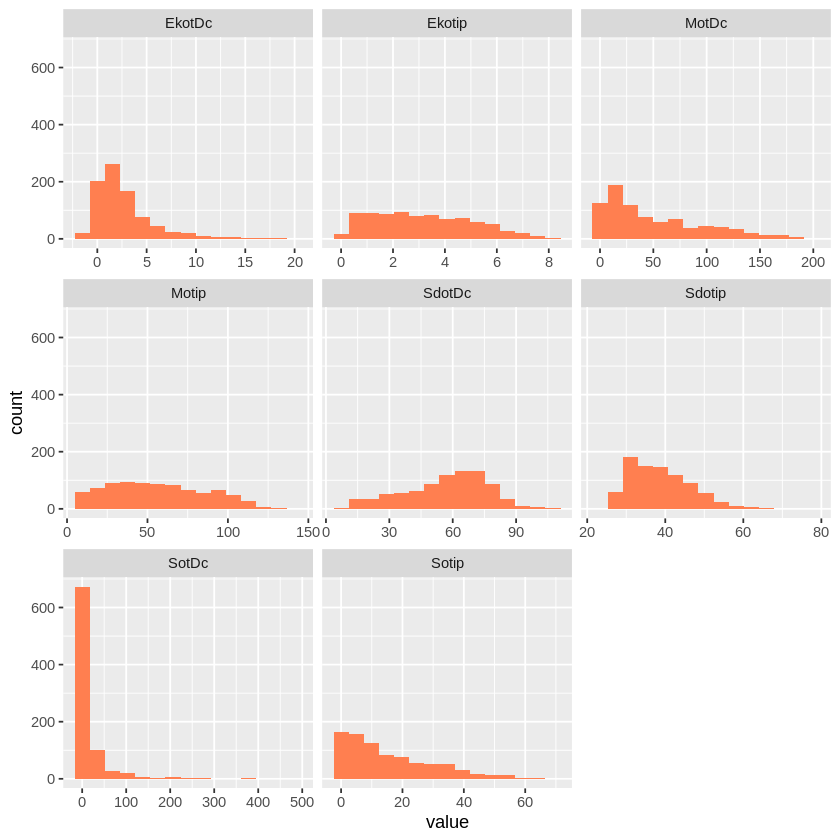

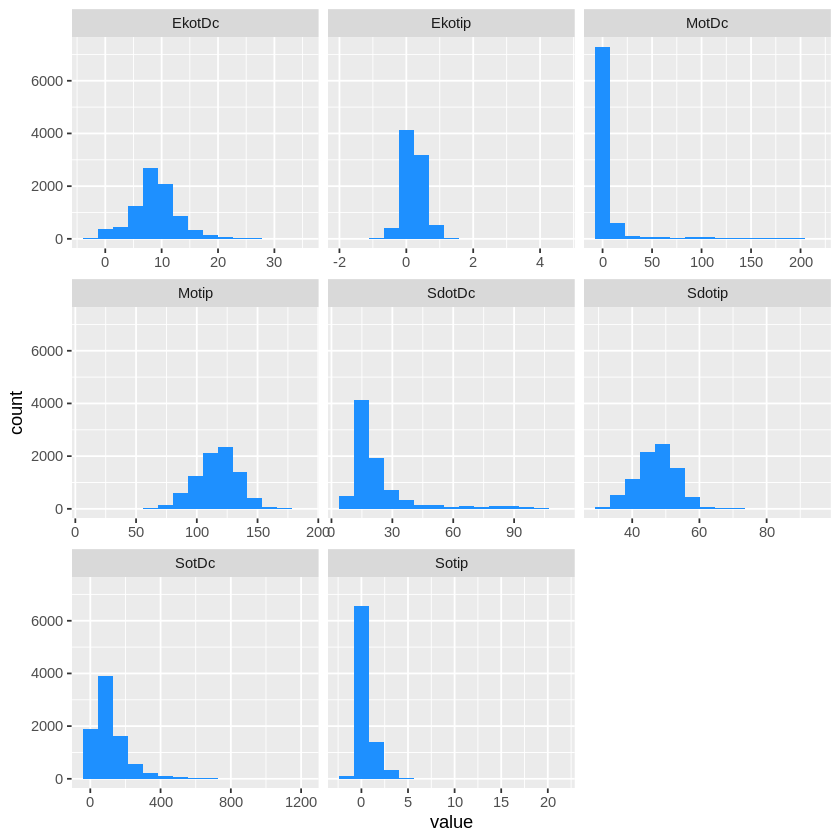

In [23]:
pulsar_pos_plot = gather(pulsar_pos) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='coral')+
facet_wrap(~key, scales = 'free_x')

pulsar_neg_plot = gather(pulsar_neg) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='dodgerblue')+
facet_wrap(~key, scales = 'free_x')

pulsar_pos_plot
pulsar_neg_plot

In [24]:
summary(pulsar_pos)
summary(pulsar_neg)

     Motip             Sdotip          Ekotip             Sotip        
 Min.   :  6.188   Min.   :24.77   Min.   :-0.09489   Min.   :-0.9601  
 1st Qu.: 32.514   1st Qu.:32.26   1st Qu.: 1.57133   1st Qu.: 3.8347  
 Median : 53.754   Median :37.33   Median : 2.98896   Median :11.2290  
 Mean   : 56.491   Mean   :38.65   Mean   : 3.14613   Mean   :15.7365  
 3rd Qu.: 78.715   3rd Qu.:43.69   3rd Qu.: 4.57130   3rd Qu.:24.7660  
 Max.   :137.930   Max.   :79.08   Max.   : 8.06952   Max.   :68.1016  
     MotDc              SdotDc            EkotDc            SotDc         
 Min.   :  0.8487   Min.   :  9.344   Min.   :-1.8623   Min.   : -1.8747  
 1st Qu.: 12.8328   1st Qu.: 44.016   1st Qu.: 0.7154   1st Qu.: -0.2465  
 Median : 34.0903   Median : 59.477   Median : 1.8531   Median :  2.3527  
 Mean   : 50.8746   Mean   : 56.665   Mean   : 2.7373   Mean   : 17.7934  
 3rd Qu.: 78.6093   3rd Qu.: 71.462   3rd Qu.: 3.6671   3rd Qu.: 13.1870  
 Max.   :199.5778   Max.   :109.655   Max.   :

     Motip            Sdotip          Ekotip              Sotip        
 Min.   : 17.21   Min.   :29.45   Min.   :-1.738021   Min.   :-1.7919  
 1st Qu.:105.32   1st Qu.:43.39   1st Qu.: 0.008649   1st Qu.:-0.2243  
 Median :117.42   Median :47.43   Median : 0.185307   Median : 0.1312  
 Mean   :116.65   Mean   :47.31   Mean   : 0.210450   Mean   : 0.3833  
 3rd Qu.:128.55   3rd Qu.:51.29   3rd Qu.: 0.390914   3rd Qu.: 0.6641  
 Max.   :189.73   Max.   :91.81   Max.   : 4.529319   Max.   :20.6954  
     MotDc              SdotDc           EkotDc           SotDc         
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.637   Min.   :  -1.977  
 1st Qu.:  1.8503   1st Qu.: 14.08   1st Qu.: 6.627   1st Qu.:  47.804  
 Median :  2.6338   Median : 17.59   Median : 8.761   Median :  90.681  
 Mean   :  8.8866   Mean   : 23.27   Mean   : 8.892   Mean   : 114.663  
 3rd Qu.:  4.2120   3rd Qu.: 24.64   3rd Qu.:10.952   3rd Qu.: 146.088  
 Max.   :211.9490   Max.   :110.64   Max.   :34.540   Max.